# Supervised Learning

In this notebook we focus on **supervised learning**, which is a set of algorithms that take **labeled** data and try to **predict** the label using the other **features** in the data. Supervised learning so far dominates applications of machine learning, although **reinforcement learning** is catching up too. Unlike **un-supervised learning** where the data is not labeled and hence there's a lot of subjectivity, **supervised learning** algorithms, once trained on data, can easily be evaluated by just comparing their **predictions** to the **labels** (in this context, we refer to the labels sometimes as **ground truth**).

As usual, let's begin by reading some data. We use a medical data that evaluates pathologists' observations and conclusions about breast biopsies.  The target `Malignant` is binary and indicates whether the tumor is malignant or not.

You can read more about the data here:
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

In [1]:
import pandas as pd
import numpy as np

# Regressors
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Accuracy Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
BreastCancer = pd.read_csv(url, header=None)
#BreastCancer = pd.read_csv("breast-cancer-wisconsin.csv", header=None)
column_names = ['ID', 'Thick', 'Size', 'Shape', 'Margin', 'CellSize', 'Nuclei', 'Chromatin', 'Nucleoli', 'Mitoses', 'Malignant']
BreastCancer.columns = column_names

The first steps of mandatory EDA are:
1. get the size of the dataset
2. get the data types of the columns
3. view the first few rows of the dataframe

In [3]:
print(BreastCancer.shape)
print(BreastCancer.dtypes)
BreastCancer.head()

(699, 11)
ID            int64
Thick         int64
Size          int64
Shape         int64
Margin        int64
CellSize      int64
Nuclei       object
Chromatin     int64
Nucleoli      int64
Mitoses       int64
Malignant     int64
dtype: object


,ID,Thick,Size,Shape,Margin,CellSize,Nuclei,Chromatin,Nucleoli,Mitoses,Malignant
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Note that the `Nuclei` column should be numeric but is actually of type object.  Let's look at the different entries in the `Nuclei` column.

In [4]:
BreastCancer.Nuclei.value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Nuclei, dtype: int64

`Nuclei` should be numeric.  `Nuclei` is of type object because of "contaminating" question marks ("?") that represent missing values.  The missing values should be nulls.  We need to cast `Nuclei`  to numeric and as a side-effect the "?" will turn into nulls.  Later we will impute values for these nulls.

In [5]:
BreastCancer.Nuclei = pd.to_numeric(BreastCancer.Nuclei, errors='coerce')
BreastCancer.Nuclei.value_counts(dropna = False)

1.0     402
10.0    132
2.0      30
5.0      30
3.0      28
8.0      21
4.0      19
NaN      16
9.0       9
7.0       8
6.0       4
Name: Nuclei, dtype: int64

Let's create a quick survey of the data using `pandas`' `describe` method

In [6]:
BreastCancer.describe()

,ID,Thick,Size,Shape,Margin,CellSize,Nuclei,Chromatin,Nucleoli,Mitoses,Malignant
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


We can see that `Nuclei` is the only column with nulls.  Let's note down the locations of the missing values.  We will impute them, later.

In [7]:
# Remember the locations
MissingNuclei = BreastCancer.Nuclei.isna()

The target is called `Malignant` and contains values 2 for not malignant and 4 for malignant.  We will relabel 2 with 'no' and 4 with 'yes'.

In [8]:
print('BreastCancer.Malignant:')
print(BreastCancer.Malignant.value_counts())
BreastCancer.loc[BreastCancer.Malignant == 4, 'Malignant'] = 'yes'
BreastCancer.loc[BreastCancer.Malignant == 2, 'Malignant'] = 'no'
print(BreastCancer.Malignant.value_counts())

BreastCancer.Malignant:
2    458
4    241
Name: Malignant, dtype: int64
no     458
yes    241
Name: Malignant, dtype: int64


## Imputation of Missing Variables
We can see from the table above that we are missing 16 values for `Nuclei`.  Previously, we removed rows or columns with missing variables or we used the sample average as the imputation value.  We can improve on the previous imputaton by creating a predictive model for imputation.  The predictive model uses all the input features except the feature (`Nuclei`) that has the missing values.  We will use supervised learning to create a regression.  This regression is a "helper" model for the "real" model which will be a classification.

We may need to use this imputation on operational data that also lack `Nuclei`.  Therefore, we cannot use the values for `Malignant` as they will not be available in operational data.  For supervised learning we split our data into test and train sets.  We do not use the rows that have missing data.

In [9]:
CompleteRows = BreastCancer.loc[~MissingNuclei,:]
inputFeatures = [x for x in CompleteRows.columns if x not in ["ID", "Nuclei", "Malignant"]]

X = CompleteRows[inputFeatures] # features
y = CompleteRows.Nuclei # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

We train and test our "helper" regression that estimates the number of nuclei.

Support Vector Regressor
Coefficient of Determinations for imputations Test: 0.59; Train: 0.76


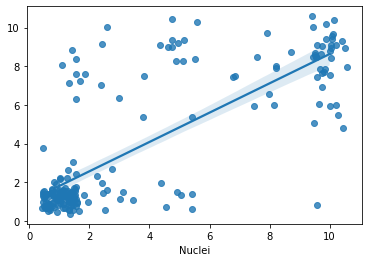

In [10]:
#rf_regress = RandomForestRegressor(); print(Random Forest Regressor)
#rf_regress = KNeighborsRegressor(); print(K-Nearest Neighbors Regressor)
#rf_regress = LinearRegression(); print(Linear Regression)
#rf_regress = Ridge(); print('Ridge Linear Regression')
#rf_regress = Lasso(); print('Lasso Linear Regression')
rf_regress = SVR(); print('Support Vector Regressor')

rf_regress.fit(X_train, y_train)
y_test_hat = rf_regress.predict(X_test)
y_train_hat = rf_regress.predict(X_train)
from sklearn.metrics import r2_score
print("Coefficient of Determinations for imputations Test: {:.2f}; Train: {:.2f}"
      .format(r2_score(y_test, y_test_hat), r2_score(y_train, y_train_hat)))
sns.regplot(x=y_test, y=y_test_hat, x_jitter=0.6, y_jitter=0.6);
plt.show()

We use the "helper" regression to predict (impute) the number of nuclei for the missing values in `Nuclei`. Jitter is a randomizer.  Let's also see the results.

In [11]:
ImputedNuclei = rf_regress.predict(BreastCancer.loc[MissingNuclei,inputFeatures]).round()
ImputedNuclei[ImputedNuclei < 1] = 1
ImputedNuclei[ImputedNuclei > 10] = 10
BreastCancer.loc[MissingNuclei, 'Nuclei'] = ImputedNuclei
ImputedNuclei

array([ 7., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  6.,  1.,  3.,  8.,
        1.,  1.,  1.])

In [12]:
display(BreastCancer.describe())
BreastCancer.head()

,ID,Thick,Size,Shape,Margin,CellSize,Nuclei,Chromatin,Nucleoli,Mitoses
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.527897,3.437768,2.866953,1.589413
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,3.631722,2.438364,3.053634,1.715078
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


,ID,Thick,Size,Shape,Margin,CellSize,Nuclei,Chromatin,Nucleoli,Mitoses,Malignant
0,1000025,5,1,1,1,2,1.0,3,1,1,no
1,1002945,5,4,4,5,7,10.0,3,2,1,no
2,1015425,3,1,1,1,2,2.0,3,1,1,no
3,1016277,6,8,8,1,3,4.0,3,7,1,no
4,1017023,4,1,1,3,2,1.0,3,1,1,no


We can save our processed data in case we want to skip the processing, next time.

In [ ]:
BreastCancer.to_csv(path_or_buf="breast-cancer-wisconsin-processed.csv", index=False)
# BreastCancer = pd.read_csv("breast-cancer-wisconsin-processed.csv")

The input features for our classifier must not contain the target `Malignant` and should not contain the IDs.  We will create randomly distributed test and train sets.  We will use the majority for training to ensure a better model.  We will use just enough test examples for a usable accuracy assessment.

In [ ]:
inputFeatures = [x for x in BreastCancer.columns if x not in ["ID", "Malignant"]]

X = BreastCancer[inputFeatures] # features
y = BreastCancer.Malignant # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

We choose a classification algorithm.  A decision tree will yield the most understandable results

In [ ]:
# clf = LogisticRegression(); print ('Logistic Regression')
# clf = GaussianNB(); print ('Naive Bayes')
# clf = KNeighborsClassifier(n_neighbors=5); print ('K-Nearest Neighbors')
# clf = SVC(gamma='auto'); print ('Support Vector Machine')
# clf = RandomForestClassifier(); print ('Random Forest')
clf = DecisionTreeClassifier(); print ('Decision Tree')
clf.fit(X_train, y_train)

Now that we have trained the decision tree classifier, we need to test it.  First we need to check our baseline accuracy.  A baseline accuracy is the accuracy that we would get, if we were to randomly guess.  

In [ ]:
ProportionOfYes = np.sum(y_test == 'yes')/y_test.shape[0]
ProportionOfYes

If we always choose the major class, then we will be right most of the time.  That is our baseline accuracy and we need to be significantly better than the baseline accuracy.

In [ ]:
print("Accuracy baseline on the test data: {:.0f}%.".format(100*max(ProportionOfYes, 1.0-ProportionOfYes)))

Now that we know the baseline accuacy, we will determine the decision tree's accuracy.

In [ ]:
# Apply the Model
y_test_hat = clf.predict(X_test)

# Evaluate Model
print("Accuracy: {:.2}".format(accuracy_score(y_test, y_test_hat)))
conmat=confusion_matrix(y_test, y_test_hat)
cmd = ConfusionMatrixDisplay(confusion_matrix=conmat, display_labels=["no", "yes"])
font = {'weight' : 'bold', 'size'   : 32}
plt.rc('font', **font)
cmd.plot();
plt.rcdefaults();

Model interpretability and explainability is an important topic.  We want to understand why the machine makes its predictions.  We can view the decsion tree and gain insights into the machine's method of prediction.

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(40,10))
font = {'size'   : 14}
plt.rc('font', **font)
plot_tree(clf, feature_names=inputFeatures)
plt.savefig("Decision_Tree_Breast_Cancer_Diagnosis.png") #save as png